In [1]:
import mlflow
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_pickle("experiments/crowd_train_all_data_embedded.pkl")

In [3]:
def get_dataframe(df, min_count, max_count, max_filter=None):
    df_temp = df.copy()

    freq = df_temp.source_id.value_counts()
    if max_filter:
        freq = freq[(min_count <= freq) & (freq <= max_filter)]
    else:
        freq = freq[min_count <= freq]
    df_temp = df_temp[df.source_id.isin(freq.index)]

    df_temp = (
        df_temp.groupby("source_id")
        .apply(lambda x: x.nlargest(max_count, "duration"))
        .reset_index(drop=True)
        .drop(
            columns=[
                "duration",
                "hash_id",
                "annotator_emo",
                "golden_emo",
                "annotator_id",
                "speaker_text",
                "speaker_emo",
            ]
        )
    )

    df_temp.dropna(inplace=True)

    print(df_temp.source_id.nunique())

    return df_temp


df_t = get_dataframe(df, 200, 10)
not_in_df_t = get_dataframe(df, 0, 3, max_filter=10)

df_t.shape[0], not_in_df_t.shape[0]

102
316


(1020, 907)

In [4]:
X = np.vstack(df_t.audio_feature.to_numpy()).reshape(df_t.shape[0], -1)
le = LabelEncoder()
y = le.fit_transform(df_t.source_id)
X_mfccs = X[:, 36 + 384: 36 + 384 + 60]  # mfcc only

X.shape, X_mfccs.shape, y.shape

((1020, 498), (1020, 60), (1020,))

In [5]:
X_not = np.vstack(not_in_df_t.audio_feature.to_numpy()).reshape(
    not_in_df_t.shape[0], -1
)
le_not = LabelEncoder()
y_not = le.fit_transform(not_in_df_t.source_id)
X_mfccs_not = X_not[:, 36 + 384: 36 + 384 + 60]  # mfcc only

X_not.shape, X_mfccs_not.shape, y_not.shape

((907, 498), (907, 60), (907,))

In [6]:
def get_model_and_params(experiment_name: str, model_name: str, model_type: str = 'sklearn'):
    experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
        'experiment_id'
    ]

    cls_102_5_df = mlflow.search_runs(
        [experiment_id], order_by=['metrics.f1_weighted'])
    svc_df = cls_102_5_df[cls_102_5_df['tags.mlflow.runName'] == model_name]
    model_dict = dict(
        eval(
            svc_df['tags.mlflow.log-model.history'].item().replace('null', 'None'))[0]
    )
    logged_model = '/'.join(
        ['runs:', model_dict['run_id'], model_dict['artifact_path']]
    )

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    loaded_model = eval(f'mlflow.{model_type}.load_model(logged_model)')

    params = (
        svc_df[svc_df.columns[svc_df.columns.str.startswith('params.')]]
        .dropna(axis=1)
        .to_dict()
    )
    params = {k.split('.')[-1]: list(v.values())[-1]
              for k, v in params.items()}
    for k, v in params.items():
        if v.isdigit():
            v = int(v)
        elif v.replace('.', '').isdigit():
            v = float(v)
        params[k] = v

    return loaded_model, params

# SVM, 102 класса, mfcc фичи

In [7]:
experiment = "only mfcc 102 classes"
model_name = "svc gsc"
loaded_model, params = get_model_and_params(experiment, model_name)

2024/05/10 16:03:53 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_mfccs, y, test_size=0.5, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [9]:
preds_val = loaded_model.predict(X_val_scaled)
metrics.f1_score(y_val, preds_val, average="weighted")

0.8556857086268851

Модели, построенные методом опорных опорных векторов, не являются вероятностными, а следовательно требуют какого-либо классификатора на своих выходах, чтобы получить вероятности на основе их предсказаний (которые являются расстояниями до наиближайших опорных векторов). При параметре probability = True используется логистическая регрессия для получения вероятностей, которая не очень хорошо справляется с этой задачей (например, не выполняется y_pred == argmax(probabilities)), decision_function также не помогла нормально посчитать расстояния, потому что различия между ними очень малы и подобрать какой-то адекватный порог на них не представляется возможным. По этой причине я использую класс CalibratedClassifierCV для получения вероятностей, который использует изотоническую регрессию и кросс-валидацию при обучении, для обеспечения лучшего результата. Как показано ниже, метрика на валидации упала всего на 0.001, но позволило напрямую работать с вероятностями.

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

params = {"kernel": "rbf", "decision_function_shape": "ovr", "C": 5}
model = SVC(**params)
calibrated = CalibratedClassifierCV(model, method="isotonic", cv=5)
calibrated.fit(X_train_scaled, y_train)
calibrated_probs = calibrated.predict_proba(X_val_scaled)

In [11]:
# f1 мера для svm и изометрической регрессии
preds_val = calibrated.predict(X_val_scaled)
metrics.f1_score(y_val, preds_val, average="weighted")

0.854234599822835

In [12]:
# вероятность, когда модель правильно классифицировала
true_probs = np.max(calibrated_probs, axis=1)[preds_val == y_val]
true_probs.mean()

0.7432785292376581

In [13]:
false_probs = np.max(calibrated_probs, axis=1)[preds_val != y_val]
false_probs.mean()

0.5586797794527484

In [14]:
scaler_not = StandardScaler()
X_mfccs_not_scaled = scaler.fit_transform(X_mfccs_not)
calibrated_probs_not = calibrated.predict_proba(X_mfccs_not_scaled)
not_probs = np.max(calibrated_probs_not, axis=1)
not_probs.mean()

0.5849930826728947

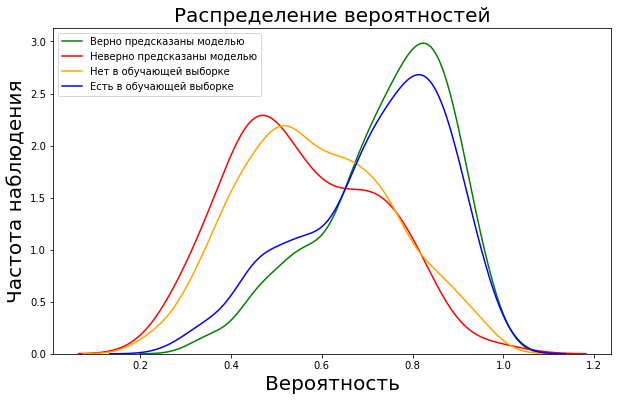

In [15]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title('Распределение вероятностей', size=20)
sns.kdeplot(true_probs, color='green', label='Верно предсказаны моделью')
sns.kdeplot(false_probs, color='red', label='Неверно предсказаны моделью')
sns.kdeplot(not_probs, color='orange', label='Нет в обучающей выборке')
sns.kdeplot(all_probs, color='blue', label='Есть в обучающей выборке')

plt.ylabel('Частота наблюдения', size=20)
plt.xlabel('Вероятность', size=20)
plt.legend()

Визуально можно оценить, что наилучший порог лежит примерно около 0,7

Для поиска наилучшего порога, используемого для разделения воспользуюсь площадью под pr кривой. Для моей задачи более важна полнота, но также должна учитываться и точность, из-за чего я и использую f-меру, но не со стандартным значением beta=1, а меньшим значением (0.8 было выбрано из эврестического понимания задачи, после визуализации выше).

In [16]:
in_df = np.hstack([np.stack([all_probs, np.ones(all_probs.shape)]), np.stack([not_probs, np.zeros(not_probs.shape)])])

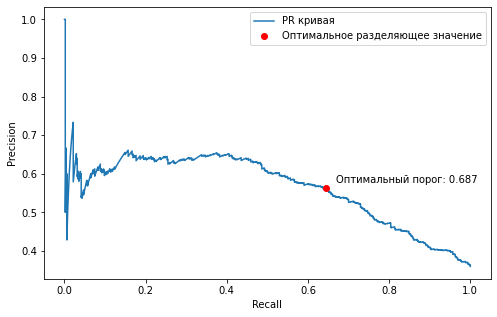

In [17]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(in_df[1, :], in_df[0, :])
beta = 0.8
f1_scores = (1 + beta**2)*recall*precision / (recall + beta**2 * precision)

idx_max_f1 = np.argmax(f1_scores)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='PR кривая')
plt.scatter(recall[idx_max_f1], precision[idx_max_f1], color='red', 
            label='Оптимальное разделяющее значениe', zorder=3)
plt.annotate(f'Оптимальный порог: {round(thresholds[idx_max_f1], 3)}', (recall[idx_max_f1], precision[idx_max_f1]), 
    textcoords='offset points', xytext=(10, 5))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


In [18]:
# точность в каждой группе после разделения по пороговому значению
true_trsh = in_df[1, :][in_df[0, :] > thresholds[idx_max_f1]]
false_trsh = in_df[1, :][in_df[0, :] < thresholds[idx_max_f1]]

sum(true_trsh)/len(true_trsh), (len(false_trsh) - sum(false_trsh))/len(false_trsh)

(0.5616438356164384, 0.7824519230769231)

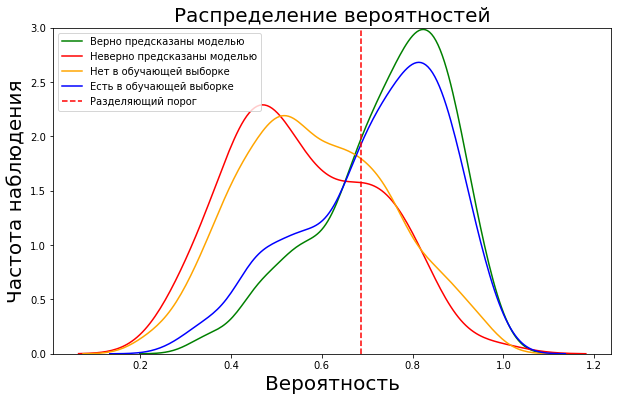

In [19]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title('Распределение вероятностей', size=20)
sns.kdeplot(true_probs, color='green', label='Верно предсказаны моделью')
sns.kdeplot(false_probs, color='red', label='Неверно предсказаны моделью')
sns.kdeplot(not_probs, color='orange', label='Нет в обучающей выборке')
sns.kdeplot(all_probs, color='blue', label='Есть в обучающей выборке')
plt.vlines(round(thresholds[idx_max_f1], 3), ymin=0, ymax=3, color='red', 
    label='Разделяющий порог', linestyle='--')

plt.ylabel('Частота наблюдения', size=20)
plt.xlabel('Вероятность', size=20)
plt.ylim(0, 3)
plt.legend()
plt.show()

Функция, для поиска оптимального порога

In [20]:
def get_pr_threshold(all_probs, not_probs, beta=0.25, plot=False):
    in_df = np.hstack([np.stack([all_probs, np.ones(all_probs.shape)]), np.stack([not_probs, np.zeros(not_probs.shape)])])

    precision, recall, thresholds = precision_recall_curve(in_df[1, :], in_df[0, :])
    f1_scores = (1 + beta**2)*recall*precision / (recall + beta**2 * precision)

    idx_max_f1 = np.argmax(f1_scores)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(recall, precision, label='PR кривая')
        plt.scatter(recall[idx_max_f1], precision[idx_max_f1], color='red', 
                    label='Оптимальное разделяющее значениe', zorder=3)
        plt.annotate(f'Оптимальный порог: {round(thresholds[idx_max_f1], 3)}', (recall[idx_max_f1], precision[idx_max_f1]), 
            textcoords='offset points', xytext=(10, 5))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    return thresholds[idx_max_f1], in_df

In [22]:
import json

with open(f'cross_validation_scores/{model_name}_threshold.json', 'w') as f:
    json.dump({'threshold': thresholds[idx_max_f1]}, f)

# catboost, 354 класса, все фичи

Предобработка данных

In [23]:
df_t = get_dataframe(df, 100, 10)
not_in_df_t = get_dataframe(df, 0, 13, max_filter=18)

X = np.vstack(df_t.audio_feature.to_numpy()).reshape(df_t.shape[0], -1)
le = LabelEncoder()
y = le.fit_transform(df_t.source_id)

X_not = np.vstack(not_in_df_t.audio_feature.to_numpy()).reshape(
    not_in_df_t.shape[0], -1
)
le_not = LabelEncoder()
y_not = le.fit_transform(not_in_df_t.source_id)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

354
408


загрузка модели

In [24]:
experiment = "354 classes, 5 per class"
model_name = "catboost tuned"
loaded_model, params = get_model_and_params(experiment, model_name, model_type='catboost')

In [25]:
preds_val = loaded_model.predict(X_val)
metrics.f1_score(y_val, preds_val, average="weighted")

0.8702095142773109

In [26]:
cb_probs = loaded_model.predict_proba(X_val)

In [27]:
# вероятность, когда модель правильно классифицировала
true_probs = np.max(cb_probs, axis=1)[np.array([preds_val == y_val.reshape(-1, 1)]).flatten()]

false_probs = np.max(cb_probs, axis=1)[np.array([preds_val != y_val.reshape(-1, 1)]).flatten()]

predict_proba_not = loaded_model.predict_proba(X_not)
not_probs = np.max(predict_proba_not, axis=1)

all_probs = np.max(cb_probs, axis=1)

true_probs.mean(), false_probs.mean(), not_probs.mean(), all_probs.mean()

(0.4776358659662475,
 0.15268437161150378,
 0.12575967079519426,
 0.4366956494458476)

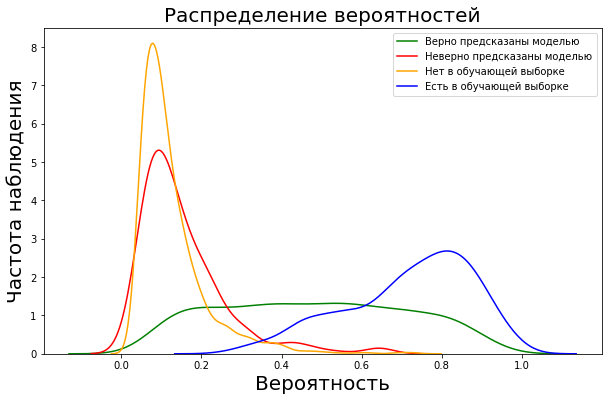

In [28]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title('Распределение вероятностей', size=20)
sns.kdeplot(true_probs, color='green', label='Верно предсказаны моделью')
sns.kdeplot(false_probs, color='red', label='Неверно предсказаны моделью')
sns.kdeplot(not_probs, color='orange', label='Нет в обучающей выборке')
sns.kdeplot(all_probs, color='blue', label='Есть в обучающей выборке')

plt.ylabel('Частота наблюдения', size=20)
plt.xlabel('Вероятность', size=20)
plt.legend()

Как видно из графика, рассмотренные классы принадлежности к выборке намного легче различимы. Порог лежит примерно около 0.2 - 0.3. Найду её также с помощью pr кривой. Коэффициент beta > 1, что говорил о смещении в сторону точности. Мой выбор связан с тем, что вероятности принадлежности к верному классу распределены довольно равномерно, из-за чего поставив высокий порог и получив отличный recall, я получу низкий precision, в то время как исходя из визуализации лучший порого находится примерно около 0.25, а не у 0.7, который максимизует recall.

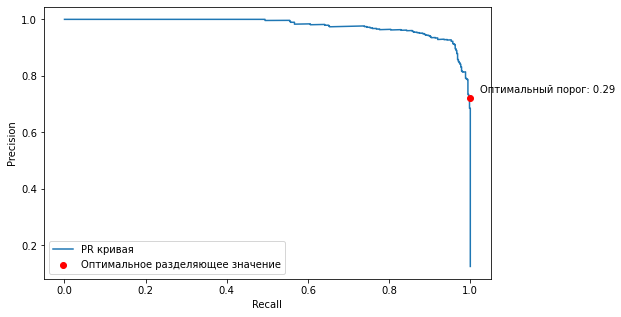

0.2896592301118485

In [29]:
threshold, in_df = get_pr_threshold(all_probs, not_probs, beta=6, plot=True)
threshold

In [30]:
# точность в каждой группе после разделения по пороговому значению
true_trsh = in_df[1, :][in_df[0, :] > threshold]
false_trsh = in_df[1, :][in_df[0, :] < threshold]

sum(true_trsh)/len(true_trsh), (len(false_trsh) - sum(false_trsh))/len(false_trsh)

(0.7226173541963016, 0.9997021149836163)

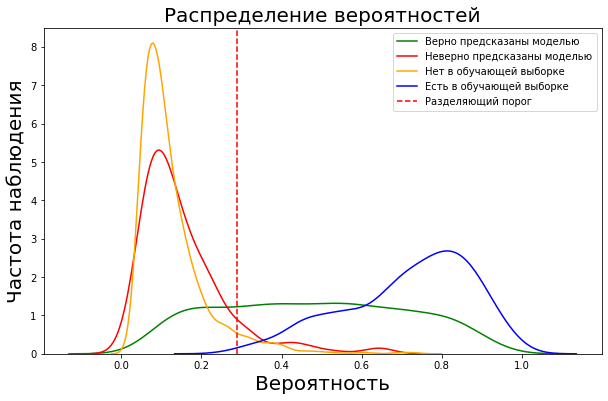

In [31]:
plt.figure(figsize=(10, 6))
plt.title('Распределение вероятностей', size=20)
sns.kdeplot(true_probs, color='green', label='Верно предсказаны моделью')
sns.kdeplot(false_probs, color='red', label='Неверно предсказаны моделью')
sns.kdeplot(not_probs, color='orange', label='Нет в обучающей выборке')
sns.kdeplot(all_probs, color='blue', label='Есть в обучающей выборке')
plt.vlines(round(threshold, 3), ymin=0, ymax=8.5, color='red', 
    label='Разделяющий порог', linestyle='--')

plt.ylabel('Частота наблюдения', size=20)
plt.xlabel('Вероятность', size=20)
plt.ylim(0, 8.5)
plt.legend()
plt.show()

In [32]:
import json

with open(f'cross_validation_scores/{model_name}_threshold.json', 'w') as f:
    json.dump({'threshold': threshold}, f)

Сравнивая две рассмотренные модели, закономерности, выявленные catboost'ом работают лучше, ведь его графики распредления представленных и не представленных в датасета классов хорошо разделимы, в отличии от svm модели, где они почти-что пересекаются

Исходя из этого, итоговой моделью, для которой я построю простой интерфейс для взаимодействия, будет именно catboost на 354 класса, обученный на всех признаках, полученных из аудиодорожки.